In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

In [3]:
train_dataset = torchvision.datasets.MNIST(root = "./data" , train = True , download = True ,  transform = transform)
valid_dataset = torchvision.datasets.MNIST(root = "./data" , train = False , download = True ,  transform = transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16213550.84it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 497935.24it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3791031.40it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4743657.56it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [140]:
train_dl = torch.utils.data.DataLoader(train_dataset , batch_size = 16)
val = torch.utils.data.DataLoader(valid_dataset , batch_size = 16)

In [141]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, latent_dimensions, data_shape):
        super(SimpleAutoencoder, self).__init__()
        self.latent_dimensions = latent_dimensions
        self.data_shape = data_shape

        # Encoder with dropout
        self.encoder = nn.Sequential(
            nn.Linear(784, 194),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(194, 97),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(97, latent_dimensions),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dimensions, 97),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(97, 194),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(194, data_shape[0] * data_shape[1]),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded_data = self.encoder(x)
        decoded_data = self.decoder(encoded_data)
        return decoded_data


In [160]:
latent_dimensions = 48
data_shape = (28, 28)
model = SimpleAutoencoder(latent_dimensions, data_shape)

In [161]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [162]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [163]:
train_loss = []
valid_loss = []

In [164]:
num_epochs = 100

In [165]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [166]:
for epoch in range(num_epochs):
  train_epoch_loss = 0
  dev_epoch_loss = 0
  for (imgs , _) in train_dl:
    imgs = imgs.to(device)
    imgs = imgs.flatten(1)
    output = model(imgs)
    loss = loss_fn(output.view(-1,784) , imgs)
    train_epoch_loss += loss.cpu().detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  scheduler.step()
  print(f"epoch {epoch} loss {train_epoch_loss/len(train_dl)}")
  train_loss.append(train_epoch_loss/len(train_dl))
  with torch.no_grad():
    for (imgs , _) in val:
      imgs = imgs.to(device)
      imgs = imgs.flatten(1)
      output = model(imgs)
      loss = loss_fn(output.view(-1,784) , imgs)
      dev_epoch_loss += loss.cpu().detach().numpy()
    print(f"dev loss {dev_epoch_loss/len(val)}")
    valid_loss.append(dev_epoch_loss/len(val))
torch.save(model.state_dict(), 'model_weights.pth')

epoch 0 loss 0.03891587268412113
dev loss 0.03205638944208622
epoch 1 loss 0.028846412083258232
dev loss 0.02839454090297222
epoch 2 loss 0.026959097391366958
dev loss 0.026892608654499054
epoch 3 loss 0.025910016760478417
dev loss 0.025912522698938848
epoch 4 loss 0.025260299269855024
dev loss 0.02606957444548607
epoch 5 loss 0.023576925864070654
dev loss 0.023118299855291843
epoch 6 loss 0.023070020895948014
dev loss 0.022912877969443798
epoch 7 loss 0.022915181212872268
dev loss 0.022706371928751468
epoch 8 loss 0.02277825598369042
dev loss 0.022602790673077106
epoch 9 loss 0.022662572237849236
dev loss 0.022575938723981382
epoch 10 loss 0.022523514754573506
dev loss 0.022302880573272704
epoch 11 loss 0.022444350143273673
dev loss 0.022429132260382175
epoch 12 loss 0.022460950321455796
dev loss 0.02224073519408703
epoch 13 loss 0.02245147349064549
dev loss 0.02229276271313429
epoch 14 loss 0.02242391629368067
dev loss 0.0222304186463356


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

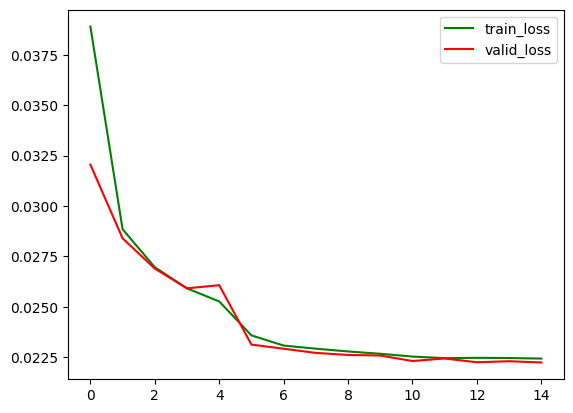

In [167]:
import matplotlib.pyplot as plt

plt.plot(train_loss, color='green', label='train_loss')
plt.plot(valid_loss, color='red', label='valid_loss')
plt.legend()
plt.show()


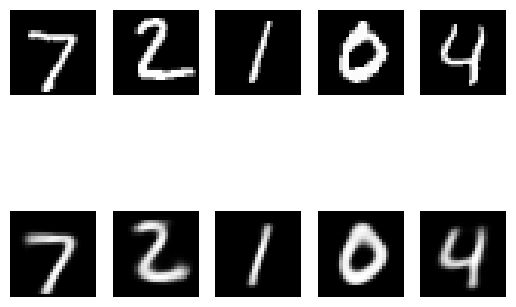

In [178]:
import matplotlib.pyplot as plt

# Get the first 5 images from the validation set
images = valid_dataset.data[:5]
# images = train_dataset.data[:5]

images = images.to(device)
# images = images.flatten(1)
images =  images/255.0

# Get the labels for the first 5 images
# Pass the images through the autoencoder
encoded_images = model.encoder(images.view(-1, 784))
decoded_images = model.decoder(encoded_images)

# Plot the original and decoded images side by side
for i in range(5):
  plt.subplot(2, 5, i + 1)
  plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
  plt.axis('off')
  plt.subplot(2, 5, i + 6)
  plt.imshow(decoded_images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
  plt.axis('off')
plt.show()


In [170]:
from torchsummary import summary
summary(model, (1, 28*28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 194]         152,290
              ReLU-2               [-1, 1, 194]               0
           Dropout-3               [-1, 1, 194]               0
            Linear-4                [-1, 1, 97]          18,915
              ReLU-5                [-1, 1, 97]               0
           Dropout-6                [-1, 1, 97]               0
            Linear-7                [-1, 1, 48]           4,704
            Linear-8                [-1, 1, 97]           4,753
           Dropout-9                [-1, 1, 97]               0
             ReLU-10                [-1, 1, 97]               0
           Linear-11               [-1, 1, 194]          19,012
             ReLU-12               [-1, 1, 194]               0
          Dropout-13               [-1, 1, 194]               0
           Linear-14               [-1,

In [177]:
model.eval()

latent_vectors = []

with torch.no_grad():
  for imgs, _ in train_dl:
    imgs = imgs.to(device)
    imgs = imgs.flatten(1)
    latent_vectors.append(model.encoder(imgs))

# Concatenate the latent vectors into a single tensor
latent_vectors = torch.cat(latent_vectors, dim=0)

print(f"train dataset shape: {train_dataset.data.shape}, {60000 * 28 * 28}")
print(f"latent vectors shape: {latent_vectors.shape}, is {60000 * 48}")
print(f"img comressed: {28 * 28 / 48} times")

train dataset shape: torch.Size([60000, 28, 28]), 47040000
latent vectors shape: torch.Size([60000, 48]), is 2880000
img comressed: 16.333333333333332 times
